In [1]:
!pip install -qqq torch

# Mechanistic Interpretability: What's superposition?

Mechanistic interpretability is an emerging areas of research in AI focused on understanding the inner workings of neural networks. LLMs and Diffusion models have taken the world by storm in the past couple of years and despite they're jaw dropping capabilities very little is known about how and why these deep neural networks generate these outputs.

In this series of articles we'll attempt to breakdown some of the key ideas of Mechanistic Interpretability (mech interp.). We haven't found many good resources to understand the fundamentals of mech interp, there's a sense of irony in how obtuse and dense the literature on a field that aims to make it easier to understand neural nets is :sweat_smile. 

As a novice diving into this area of research my goal is to improve my understanding of the topic as we learn and also hopefully make it easier for others to learn too. The initial articles will be heavily based on a [blog](https://transformer-circuits.pub/2022/toy_model/index.html) released by Anthropic and team in 2022, the [code](https://colab.research.google.com/github/anthropics/toy-models-of-superposition/blob/main/toy_models.ipynb) encompassed in this series largely derives from it too. We found the blog quite dense for a newbie to follow so my aim is to dumb it down as much as possible. Word of caution, that even my series expects readers to have a good understanding of ML and how to train Deep Neural Networks. If you've completed a ML 101 class in your schooling you should have no trouble following these articles.

## Superposition
I came across the idea of superposition in one of 3Blue1Brown's [videos](https://www.youtube.com/watch?v=9-Jl0dxWQs8) on LLMs, and it had be intrigued right away.

Suppose your data is N-dimensional i.e. has N different features and your model projects the N-dimensional data into a smaller H-dimensional vector space. Superposition is the ability of the model to learn to represent **more features than there are dimensions**. So if we denote the number of features a model learns to represent as C i.e. **C>H**.

_Note that in the above scenario, we assume that we've gotten rid of all redundant features in our original dataset._

### Defining a Neuron
A neuron in a neural network corresponds to a group of weights. Throughout this article we define a neuron is a specific row in a weight matrix. If weight matrix W has shape [N, H]. Each row i.e. W[i] of shape (H, ) corresponds to a neuron.

### Defining Features
The notion of a feature can get murky when we speak about unstructured data vs structured data, where the former is much more subjective. In the original blog a feature is defined as "properties of the input which a sufficiently large neural network will reliably dedicate a neuron to representing.". We like to think of a feature as some property of the input that helps a model solve the task at hand.

In an ideal world we'd like to have completely disparate/distinct neurons to represent a feature. i.e. a one to one mapping between features and neurons, there've been multiple works showing how certain neurons are activated by specific features like edge detectors in vision models or entities in text based models. However in practice we see that some features might not be represented at all and/or some neurons might be **polysemantic** i.e. they are sensitive to multiple features which can seemingly be unrelated. Superposition serves as an explanation for how neurons can be polysemantic. 

## How does Superposition work?

Now that we understand what superposition is, we now need to figure out how superposition is likely to manifest and whether this predicted manifestation can be empirically seen.

One of the key assumptions of superposition is that **Features are represented as directions.** This shouldn't come as much of a surprise if you've ever worked with any kind of embedding models before, where different concepts/entities that are related to each other have high cosine similarities. Cosine similarity measure of the degree to which two vectors are pointing in the same direction. That's why a cosine similarity score of 1 corresponds to an angle of 0 degrees (cos(0) = 1).

Okay now that we know that features are represented as directions, the question is how do we figure out what directions to look at in search for these features, after all there an infinite number of directions in any n-d space (n>1). 

Superposition hypothesizes that each neuron represents the direction of a feature. i.e. each row of the W matrix is the direction we should be looking at, in search for a feature. In the original article these directions are called _privileged basis_. A basis can be thought of as a reference framework to locate any point in a given vector space. The x and y axes are examples of a basis in a 2-d space. So you can visualize each of the rows of a weight matrix i.e. each neuron as an axes in the H-D space we project the input features to.

### Superposition, Orthogonality and Interference

The dot product between two vectors represents the projection of one vector onto another. To make sense of that let's visualize "proejcting a vector onto another".

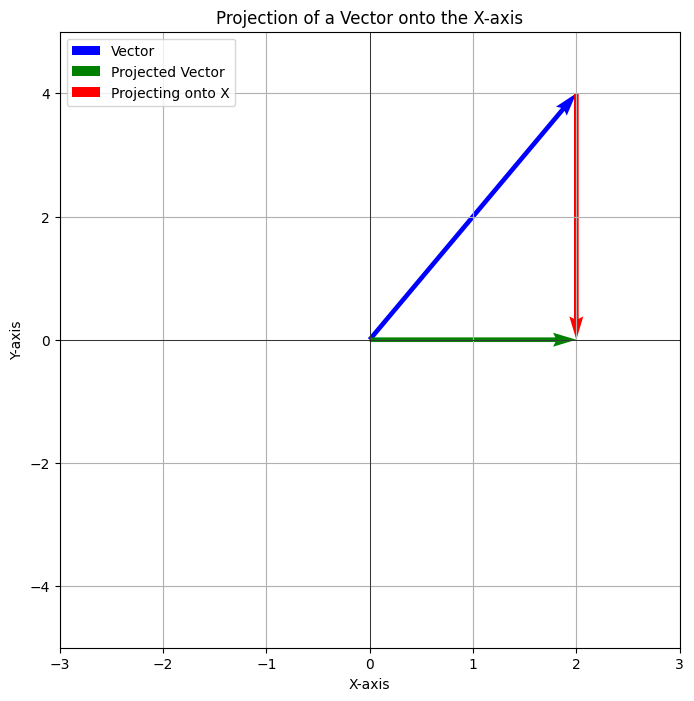

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Define the 2D vector
vector = np.array([2, 4])

# Define the x-axis unit vector
x_axis = np.array([2, 0])

# Calculate the dot product (projection onto x-axis)
projection_length = np.dot(vector, x_axis)
projection = projection_length * x_axis


# Plot the vector and its projection
plt.figure(figsize=(8, 8))
plt.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector')
plt.quiver(0, 0, x_axis[0], x_axis[1], angles='xy', scale_units='xy', scale=1, color='g', label='Projected Vector')

# Plot the projection
plt.quiver(2, 4, 0, -4, angles='xy', scale_units='xy', scale=1, color='r', label='Projecting onto X')
# Plot the x-axis
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)

# Set the limits and labels
plt.xlim(-3, 3)
plt.ylim(-5, 5)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Projection of a Vector onto the X-axis')
plt.legend()
plt.grid(True)
plt.show()


Here we see that when the vector in blue is projected onto the x-axis we see that the magnitude of the projection corresponds to its x-cordinate. Another way of stating this is that the vector **interferes** with the x-axis. Now instead of projecting the vector in blue, let's say that we attempt to project the y-axis onto the x-axis. 

Let's assume we have unit vectors along both axis y = [0, 1] and x = [1, 0]
The dot product is 0.1 + 1.0 = 0. i.e both x and y **do not interfere** with each other. Also note that x and y are orthogonal to each other. So two orthogonal vectors can not interfere with each other.

Let's tie these ideas in with superposition now. If we had the same number of features as hidden dimensions, one of the ways a neural network can learn to represent each of these features with a perfect 1-to-1 mapping is by ensuring that all the neurons i.e. all the rows of the weight matrix are orthogonal to each other. **Since the features are represented orthognally there's no interference between them.**

However, realistically speaking its impossible for there to be the same number of hidden dimensions as features. Superposition allows for a neuron to represent multiple features, since representing all the features orthogonally is impossible superposition states that features tend to be nearly orthogonal. In fact according to the Johnson–Lindenstrauss [lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma) the number of vectors that can be nearly orthogonal to each other grows exponentially with the number of dimensions.


To help with visualizing this, let's say that we have 2 features (A, B) and want to represent them in a 2-d space. Since there are 2-dims, A and B can be orthogonal to each other, for simplicity let's just say that A is represented along the x-axis and B along the y-axis.

Now, if we add another feature C it'd be impossible to make all three orthogonal to each other because we're in a 2-d space. So, instead we have to learn these features such that they minimally interfere with each other. How A, B and C are represented directionally depends on a lot of factors like the importance of each feature and their sparsity. Let's say that the importance A far outweights that of B and C, in that case A should be **interfered with as less as possible**. 

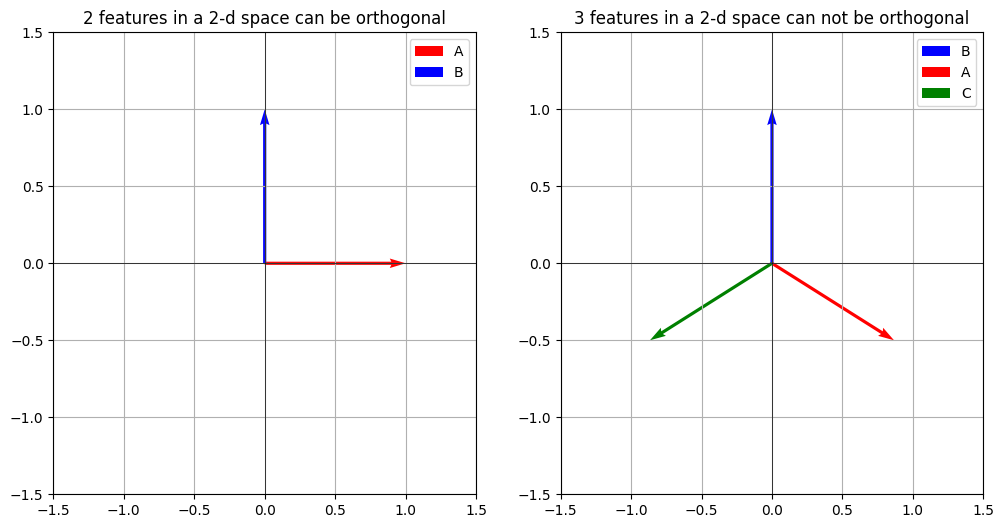

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# Define the vectors
A = np.array([1, 0])
B = np.array([0, 1])
C = np.array([1, 1])
C = C / np.linalg.norm(C)  # Normalize C to make it a unit vector

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: A and B along the x and y axis
axs[0].quiver(0, 0, A[0], A[1], angles='xy', scale_units='xy', scale=1, color='r', label='A')
axs[0].quiver(0, 0, B[0], B[1], angles='xy', scale_units='xy', scale=1, color='b', label='B')
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_ylim(-1.5, 1.5)
axs[0].axhline(0, color='k', linewidth=0.5)
axs[0].axvline(0, color='k', linewidth=0.5)
axs[0].grid(True)
axs[0].legend()
axs[0].set_title('2 features in a 2-d space can be orthogonal')

# Second subplot: B along the Y-axis, A is 120 degrees to B and C is 120 degrees to A
axs[1].quiver(0, 0, B[0], B[1], angles='xy', scale_units='xy', scale=1, color='b', label='B')
# rotate B by 120 degrees
B_120 = np.array([B[0] * np.cos(np.pi / 3) - B[1] * np.sin(np.pi / 3), B[0] * np.sin(np.pi / 3) + B[1] * np.cos(np.pi / 3)])
# rotate B by 240 degrees
B_240 = np.array([B[0] * np.cos(2 * np.pi / 3) - B[1] * np.sin(2 * np.pi / 3), B[0] * np.sin(2 * np.pi / 3) + B[1] * np.cos(2 * np.pi / 3)])
axs[1].quiver(0, 0, -B_120[0], -B_120[1], angles='xy', scale_units='xy', scale=1, color='r', label='A')
axs[1].quiver(0, 0, B_240[0], B_240[1], angles='xy', scale_units='xy', scale=1, color='g', label='C')

axs[1].set_xlim(-1.5, 1.5)
axs[1].set_ylim(-1.5, 1.5)
axs[1].axhline(0, color='k', linewidth=0.5)
axs[1].axvline(0, color='k', linewidth=0.5)
axs[1].grid(True)
axs[1].legend()
axs[1].set_title('3 features in a 2-d space can not be orthogonal')

plt.show()

### Superposition and Sparsity

Sparsity of features encourages superposition! Let's say that A, B and C are naturally sparse i.e. these features have non-zero values very rarely. In such a scenario interference becomes minimal. For e.g. if each feature has a probability of being non-zero of 0.05 (sparsity factor). The probability of all features being non-zero is 1.25e-4!

Sparsity of features is infact a very natural phenomenon. Think of the millions (if not billions) of things that an LLM knows about. For any given query only a handful of the concepts that an LLM knows are going to be relevant to answer the query. In the next section we'll get to see how sparsity coupled with a non-linearity i.e. an activation function encourages superposition.

## Exhibiting Superposition in a Toy Model

All the code shown is also available as a notebook (here)[]

In [137]:
!pip install -qqq torch

from torch import nn
import torch
import numpy as np

In [50]:
class DummyModel(nn.Module):
    def __init__(self, feature_imp: torch.Tensor, num_features: int = 5, hidden_dim: int = 2, use_relu: bool = False):
        super(DummyModel, self).__init__()
        self.W = nn.Parameter(torch.empty(num_features, hidden_dim))
        nn.init.xavier_normal_(self.W)
        self.bias = nn.Parameter(torch.zeros(num_features))
        self.use_relu = use_relu
        self.feature_imp = feature_imp
    
    def reset_weights(self):
        nn.init.xavier_normal_(self.W)
    
    def forward(self, x):
        hidden = torch.matmul(x, self.W)
        reconstructed_x = torch.matmul(hidden, self.W.T) + self.bias
        if self.use_relu:
            reconstructed_x = nn.functional.relu(reconstructed_x)
        
        return reconstructed_x

In [51]:
num_features = 5
feature_imps = 0.9 ** torch.arange(num_features)
model = DummyModel(feature_imps, num_features=5, hidden_dim=2, use_relu=False)
x = torch.rand(1, num_features)
# Run a single forward pass
output = model(x)

# Print inputs and outputs
print("Input:", x)
print("Output:", output)
# Instantiate the model


Input: tensor([[0.9176, 0.4421, 0.8276, 0.8696, 0.6213]])
Output: tensor([[ 0.7988,  0.0156,  0.7815,  0.6063, -0.1191]], grad_fn=<AddBackward0>)


In [52]:
import torch.optim as optim

def train(model, optimizer, scheduler, num_steps, batch_size, input_dim, feature_sparsity, log_interval=200):
    for step in range(num_steps):
        # Generate random batch of inputs
        inputs = torch.randn(batch_size, input_dim)
        
        # create random feature mask
        mask = torch.rand((batch_size, input_dim)) > feature_sparsity
        inputs = inputs * mask
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = (model.feature_imp * ((outputs - inputs)**2)).sum(dim=1)
        loss = loss.mean()
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Print loss every log_interval steps
        if step % log_interval == 0:
            print("Learning rate:", scheduler.get_last_lr())
            print(f'Step [{step}/{num_steps}], Loss: {loss.item():.4f}')

In [53]:
# Define loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10000)

# Training loop
num_steps = 10000
batch_size = 1024
input_dim = 5
feature_sparsity_prob = 0
model.reset_weights()
train(model, optimizer, scheduler, num_steps, batch_size, input_dim, feature_sparsity_prob)
print(model.W)

Learning rate: [0.0009999999753259891]
Step [0/10000], Loss: 5.0499
Learning rate: [0.0009990034764772327]
Step [200/10000], Loss: 2.7003
Learning rate: [0.0009960376388798247]
Step [400/10000], Loss: 2.5914
Learning rate: [0.0009911141673397982]
Step [600/10000], Loss: 2.4607
Learning rate: [0.000984252492550001]
Step [800/10000], Loss: 2.4081
Learning rate: [0.0009754796944060304]
Step [1000/10000], Loss: 2.4448
Learning rate: [0.0009648303951342477]
Step [1200/10000], Loss: 2.4238
Learning rate: [0.0009523466226536772]
Step [1400/10000], Loss: 2.4217
Learning rate: [0.0009380776447110064]
Step [1600/10000], Loss: 2.3452
Learning rate: [0.0009220797744433006]
Step [1800/10000], Loss: 2.3389
Learning rate: [0.0009044161481357741]
Step [2000/10000], Loss: 2.4130
Learning rate: [0.0008851564760517177]
Step [2200/10000], Loss: 2.3746
Learning rate: [0.000864376767317943]
Step [2400/10000], Loss: 2.3032
Learning rate: [0.0008421590299514746]
Step [2600/10000], Loss: 2.3355
Learning rate: 

In [81]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_weights(model):
    # Plot the learned weights on a 2D grid
    plt.figure(figsize=(6, 6))
    weights = model.W.detach().numpy()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(weights)))
    # Calculate the L2 norm of each weight vector
    l2_norms = np.linalg.norm(weights, axis=1)
    
    # Plot the weights with size based on their L2 norm
    plt.scatter(weights[:, 0], weights[:, 1], s=l2_norms * 100, c=colors, edgecolor='black')
    
    # Plot lines connecting the weights to the origin
    for weight in weights:
        plt.plot([0, weight[0]], [0, weight[1]], 'r--')
    
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title('2D Grid Plot of Learned Parameters')
    plt.xlabel('Parameter 1')
    plt.ylabel('Parameter 2')
    plt.grid(True)
    plt.show()
    
def plot_feature_interactions(model):
    feature_matrix = model.W.detach() @ model.W.detach().T
    plt.imshow(feature_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Feature Interactions Heatmap')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Index')
    plt.show()

def plot_bias(model):
    plt.imshow(model.bias.detach().view(1, -1), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Bias Parameters')
    plt.xlabel('Feature Index')
    plt.show()
    
def plot_interference(model):
    interference_scores = np.zeros((model.W.shape[0]))
    for i in range(model.W.shape[0]):
        interference = model.W[i].detach().view(1, -1) @ model.W.T.detach()
        interference = interference.squeeze()
        if i == 0:
            interference_scores[i] = interference[1:].sum().item()
        elif i < model.W.shape[0] - 1:
            interference_scores[i] = interference[:i].sum().item() + interference[i+1:].sum().item()
        else:
            interference_scores[i] = interference[:i].sum().item()
    
    plt.imshow(interference_scores.reshape(-1, 1), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Interference Scores')
    plt.xlabel('Feature Index')
    plt.show()

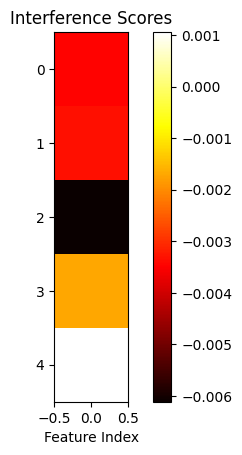

In [82]:
plot_interference(model)

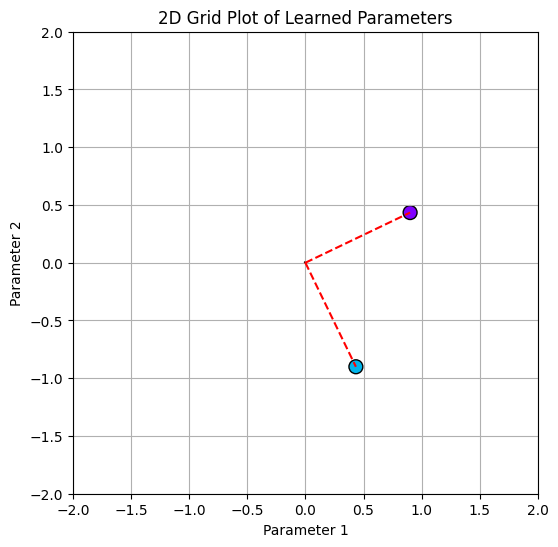

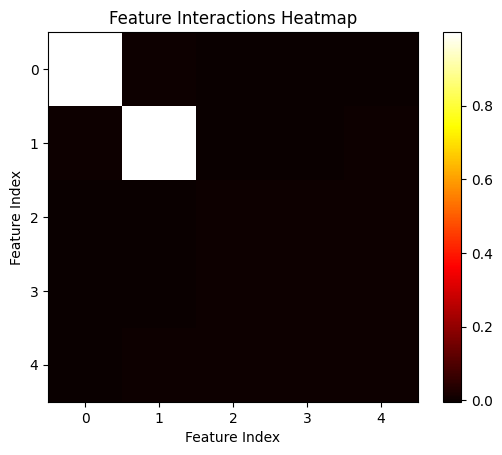

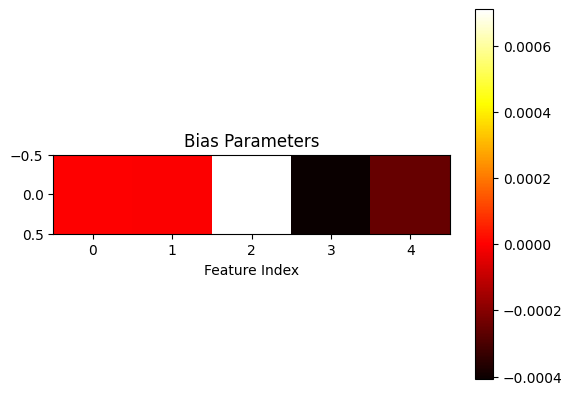

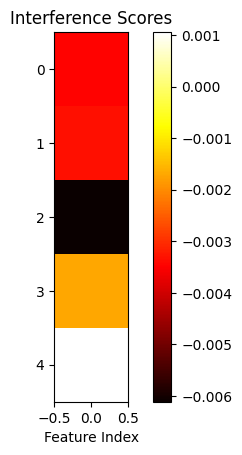

In [83]:
def plot_all(model):
    plot_model_weights(model)
    plot_feature_interactions(model)
    plot_bias(model)
    plot_interference(model)

plot_all(model)

In [32]:
import torch

def plot_angles_between_weights(model):
    num_weights = model.W.shape[0]
    angles = []

    for i in range(num_weights):
        for j in range(i + 1, num_weights):
            cosine_similarity = torch.nn.functional.cosine_similarity(model.W[i], model.W[j], dim=0)
            angle = torch.acos(cosine_similarity).item() * (180.0 / torch.pi)
            angles.append((i, j, angle))
            print(f'Angle between weights {i} and {j}: {angle:.2f} degrees')

In [33]:
plot_angles_between_weights(model)

Angle between weights 0 and 1: 45.74 degrees
Angle between weights 0 and 2: 114.06 degrees
Angle between weights 0 and 3: 119.67 degrees
Angle between weights 0 and 4: 90.92 degrees
Angle between weights 1 and 2: 68.32 degrees
Angle between weights 1 and 3: 165.41 degrees
Angle between weights 1 and 4: 136.66 degrees
Angle between weights 2 and 3: 126.27 degrees
Angle between weights 2 and 4: 155.02 degrees
Angle between weights 3 and 4: 28.75 degrees


## Train the model with sparsity without non-linearity

In [17]:
model.reset_weights()
model.use_relu = False
feature_sparsity_prob = 0.5
train(model, optimizer, scheduler, num_steps, batch_size, input_dim, feature_sparsity_prob)

Learning rate: [2.4674010778991117e-11]
Step [0/10000], Loss: 1.6919
Learning rate: [9.965235227676902e-07]
Step [200/10000], Loss: 1.6519
Learning rate: [3.962361120176886e-06]
Step [400/10000], Loss: 1.6100
Learning rate: [8.885832660203798e-06]
Step [600/10000], Loss: 1.6460
Learning rate: [1.5747507450000128e-05]
Step [800/10000], Loss: 1.6749
Learning rate: [2.4520305593971504e-05]
Step [1000/10000], Loss: 1.6057
Learning rate: [3.516960486575398e-05]
Step [1200/10000], Loss: 1.5884
Learning rate: [4.765337734632388e-05]
Step [1400/10000], Loss: 1.4137
Learning rate: [6.192235528899342e-05]
Step [1600/10000], Loss: 1.4856
Learning rate: [7.792022555669897e-05]
Step [1800/10000], Loss: 1.3725
Learning rate: [9.558385186422542e-05]
Step [2000/10000], Loss: 1.3682
Learning rate: [0.0001148435239482804]
Step [2200/10000], Loss: 1.2463
Learning rate: [0.00013562323268205572]
Step [2400/10000], Loss: 1.2706
Learning rate: [0.00015784097004852444]
Step [2600/10000], Loss: 1.2503
Learning

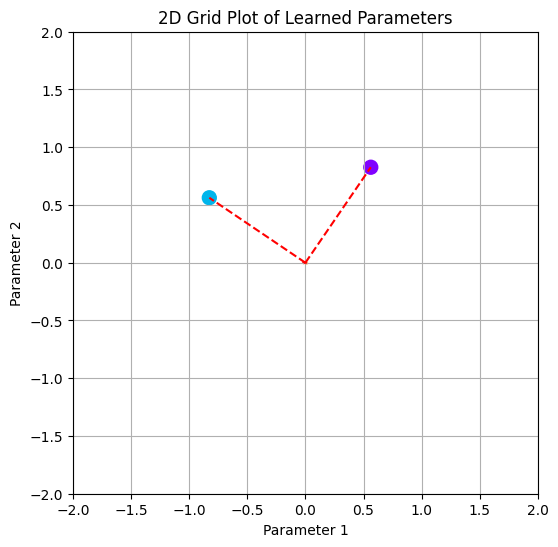

In [18]:
plot_model_weights(model)

## Train the model with sparsity and non-linearity

In [19]:
model.reset_weights()
model.use_relu = True
feature_sparsity_prob = 0.5
train(model, optimizer, scheduler, num_steps, batch_size, input_dim, feature_sparsity_prob)

Learning rate: [0.000999999975325988]
Step [0/10000], Loss: 1.6539
Learning rate: [0.0009990034764772318]
Step [200/10000], Loss: 1.6283
Learning rate: [0.0009960376388798231]
Step [400/10000], Loss: 1.4800
Learning rate: [0.0009911141673397967]
Step [600/10000], Loss: 1.5622
Learning rate: [0.0009842524925500003]
Step [800/10000], Loss: 1.5032
Learning rate: [0.0009754796944060299]
Step [1000/10000], Loss: 1.6468
Learning rate: [0.0009648303951342471]
Step [1200/10000], Loss: 1.5053
Learning rate: [0.000952346622653677]
Step [1400/10000], Loss: 1.6033
Learning rate: [0.000938077644711006]
Step [1600/10000], Loss: 1.6445
Learning rate: [0.0009220797744433001]
Step [1800/10000], Loss: 1.6411
Learning rate: [0.0009044161481357736]
Step [2000/10000], Loss: 1.5569
Learning rate: [0.0008851564760517182]
Step [2200/10000], Loss: 1.5602
Learning rate: [0.000864376767317943]
Step [2400/10000], Loss: 1.5891
Learning rate: [0.0008421590299514742]
Step [2600/10000], Loss: 1.5060
Learning rate: [0

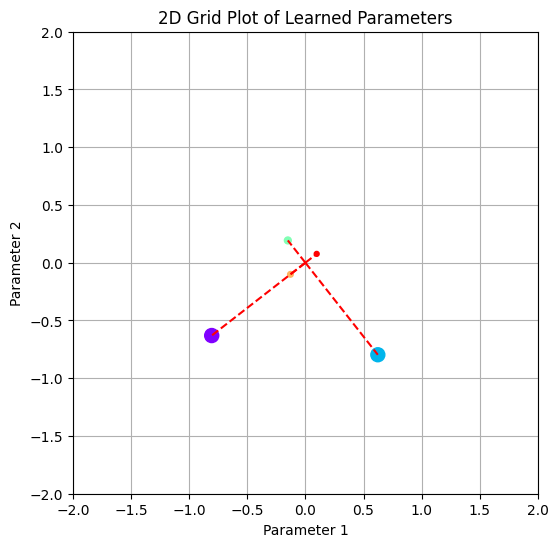

In [20]:
plot_model_weights(model)

## Train a model with high sparsity and non-linearity

In [30]:
model.reset_weights()
model.use_relu = True
feature_sparsity_prob = 0.8
train(model, optimizer, scheduler, num_steps, batch_size, input_dim, feature_sparsity_prob)

Learning rate: [0.0009999999753259896]
Step [0/10000], Loss: 0.6947
Learning rate: [0.0009990034764772325]
Step [200/10000], Loss: 0.7302
Learning rate: [0.0009960376388798242]
Step [400/10000], Loss: 0.6784
Learning rate: [0.0009911141673397978]
Step [600/10000], Loss: 0.6102
Learning rate: [0.0009842524925500024]
Step [800/10000], Loss: 0.6384
Learning rate: [0.0009754796944060304]
Step [1000/10000], Loss: 0.6657
Learning rate: [0.0009648303951342477]
Step [1200/10000], Loss: 0.6680
Learning rate: [0.0009523466226536775]
Step [1400/10000], Loss: 0.7152
Learning rate: [0.0009380776447110078]
Step [1600/10000], Loss: 0.6699
Learning rate: [0.000922079774443302]
Step [1800/10000], Loss: 0.5977
Learning rate: [0.0009044161481357758]
Step [2000/10000], Loss: 0.6136
Learning rate: [0.0008851564760517199]
Step [2200/10000], Loss: 0.6606
Learning rate: [0.0008643767673179448]
Step [2400/10000], Loss: 0.6517
Learning rate: [0.0008421590299514759]
Step [2600/10000], Loss: 0.6338
Learning rate:

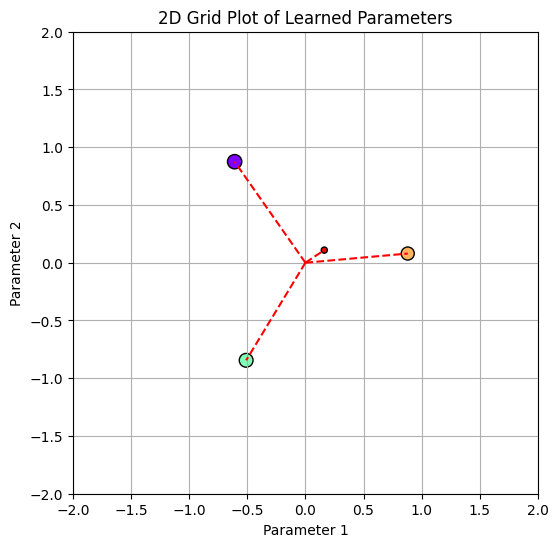

In [31]:
plot_model_weights(model)

In [28]:
model.reset_weights()
model.use_relu = True
feature_sparsity_prob = 0.9
train(model, optimizer, scheduler, num_steps, batch_size, input_dim, feature_sparsity_prob)

Learning rate: [2.4674010778991117e-11]
Step [0/10000], Loss: 0.5914
Learning rate: [9.965235227676343e-07]
Step [200/10000], Loss: 0.4542
Learning rate: [3.962361120176843e-06]
Step [400/10000], Loss: 0.4802
Learning rate: [8.885832660203776e-06]
Step [600/10000], Loss: 0.5093
Learning rate: [1.574750745000006e-05]
Step [800/10000], Loss: 0.5397
Learning rate: [2.4520305593971707e-05]
Step [1000/10000], Loss: 0.5892
Learning rate: [3.516960486575423e-05]
Step [1200/10000], Loss: 0.5613
Learning rate: [4.7653377346324156e-05]
Step [1400/10000], Loss: 0.5522
Learning rate: [6.192235528899379e-05]
Step [1600/10000], Loss: 0.4781
Learning rate: [7.792022555670034e-05]
Step [1800/10000], Loss: 0.4507
Learning rate: [9.558385186422618e-05]
Step [2000/10000], Loss: 0.4077
Learning rate: [0.00011484352394828124]
Step [2200/10000], Loss: 0.4800
Learning rate: [0.00013562323268205618]
Step [2400/10000], Loss: 0.4074
Learning rate: [0.000157840970048526]
Step [2600/10000], Loss: 0.3546
Learning 

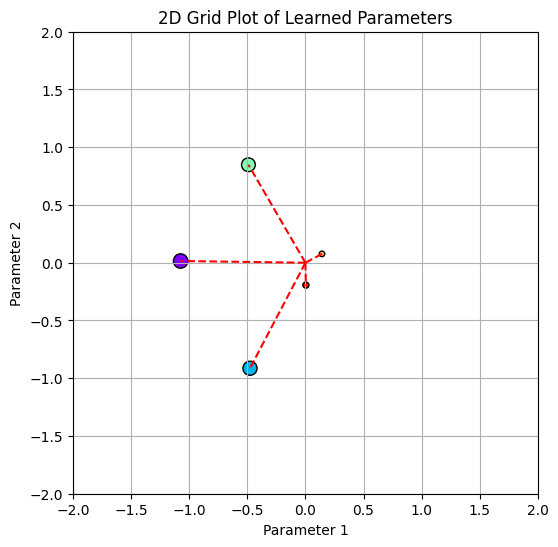

In [29]:
plot_model_weights(model)

In [ ]:
Two broad categories of companies jump to the top of my mind. The first one is a product that offers AI as a Service. Such a product will focus on creating, editing, updating, managing the lifecycle etc. the actual AI model itself, that then can be customized for specific verticals or use cases. The true value here would lie in proprietary algorithms or workflows that offer state of the art performance. A good example of this would be a model editing service. Right now models need to be trained on billions of datapoints to learn new things. A model editing service would be able to directly augment a model or edit the existing weights of the model without foregoing any kind of finetuning.

The second category is one that focuses on creating AI agents for niche verticals, where a lot of work can be either automated by the agent or the agent can serve as a virtual buddy/assistant. Examples of this are plentiful with things like Agents for managing supply chain logistics, bidding for government contracts etc. The true value here lies in identifying a niche vertical and the understanding of the different moving parts of the vertical.

In [ ]:
I'm looking for a co-founder who has the ability to learn new things and acquire new skills at a fast pace. A founder would need to dive into new problems on a regular basis and may also need to learn about completely new domains from scratch, showing a capacity and enjoyment towards learning is a must have for this reason in my opinion.

I'd also like my co-founder to have aligning moral and ethical views, success shouldn't come at the cost of doing the right thing. 

Being pragmatically optimistic and level headed are important traits too. Startups can be emotional rollercoasters and its important to see clearly during both the lows and highs to make meaningful decisions.

Clear and straightforward communication is key too, no beating around the bush. We can all be truthful and honest while being respectful.

On top of these if you are an expert in a specific business domain and are well versed on the business side of things, we'll be complementing each other's skillsets too.